In [1]:
import os
import pandas as pd

# Ruta de la carpeta que contiene los archivos CSV
folder_path = '/media/miguel/Pen Miguel/BaseDatosUmbral'

# Inicializar diccionario para almacenar resultados
attack_timestamps = {}

# Función para procesar archivos CSV en chunks
def process_csv_files(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            print(f"Procesando archivo: {file_name}")
            try:
                min_time, max_time = None, None
                for chunk in pd.read_csv(file_path, chunksize=10000):  # Leer en chunks de 10,000 filas
                    # Verificar que existe la columna 'Timestamp'
                    if 'Timestamp' not in chunk.columns:
                        print(f"La columna 'Timestamp' no está presente en {file_name}")
                        continue

                    # Limpiar el formato del Timestamp
                    chunk['Timestamp'] = chunk['Timestamp'].str.strip()
                    chunk['Timestamp'] = chunk['Timestamp'].str.replace('a. m.', 'AM', regex=False)
                    chunk['Timestamp'] = chunk['Timestamp'].str.replace('p. m.', 'PM', regex=False)

                    # Convertir a formato datetime
                    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], format='%d/%m/%Y %I:%M:%S %p', errors='coerce')

                    # Eliminar valores no válidos
                    chunk = chunk.dropna(subset=['Timestamp'])

                    # Actualizar el mínimo y máximo del chunk
                    if not chunk.empty:
                        chunk_min = chunk['Timestamp'].min()
                        chunk_max = chunk['Timestamp'].max()
                        if min_time is None or chunk_min < min_time:
                            min_time = chunk_min
                        if max_time is None or chunk_max > max_time:
                            max_time = chunk_max

                # Almacenar resultados si se encontraron valores válidos
                if min_time and max_time:
                    attack_timestamps[file_name] = {'Start Time': min_time, 'End Time': max_time}
                else:
                    print(f"No se encontraron valores válidos en 'Timestamp' para {file_name}")

            except Exception as e:
                print(f"Error procesando {file_name}: {e}")

# Ejecutar la función
process_csv_files(folder_path)

# Mostrar resultados
if attack_timestamps:
    print("\nResultados del análisis:")
    for file, timestamps in attack_timestamps.items():
        print(f"Archivo: {file}")
        print(f"  Inicio del ataque en el .pcap: {timestamps['Start Time']}")
        print(f"  Fin del ataque en el .pcap: {timestamps['End Time']}")
        print()
else:
    print("No se encontraron datos válidos en los archivos.")


Procesando archivo: BenignTraffic-.pcap_Flow.csv
Procesando archivo: BenignTraffic-1.pcap_Flow.csv
Procesando archivo: BenignTraffic-2.pcap_Flow.csv
Procesando archivo: BenignTraffic-3.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation1.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation2.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation3.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation4.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation5.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation6.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation7.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation8.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation9.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation10.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation11.pcap_Flow.csv
Procesando archivo: DDoS-ACK_Fragmentation12.pcap_Flow.csv
Procesando archivo: DDoS-HTTP_Flood-.pcap_Flo

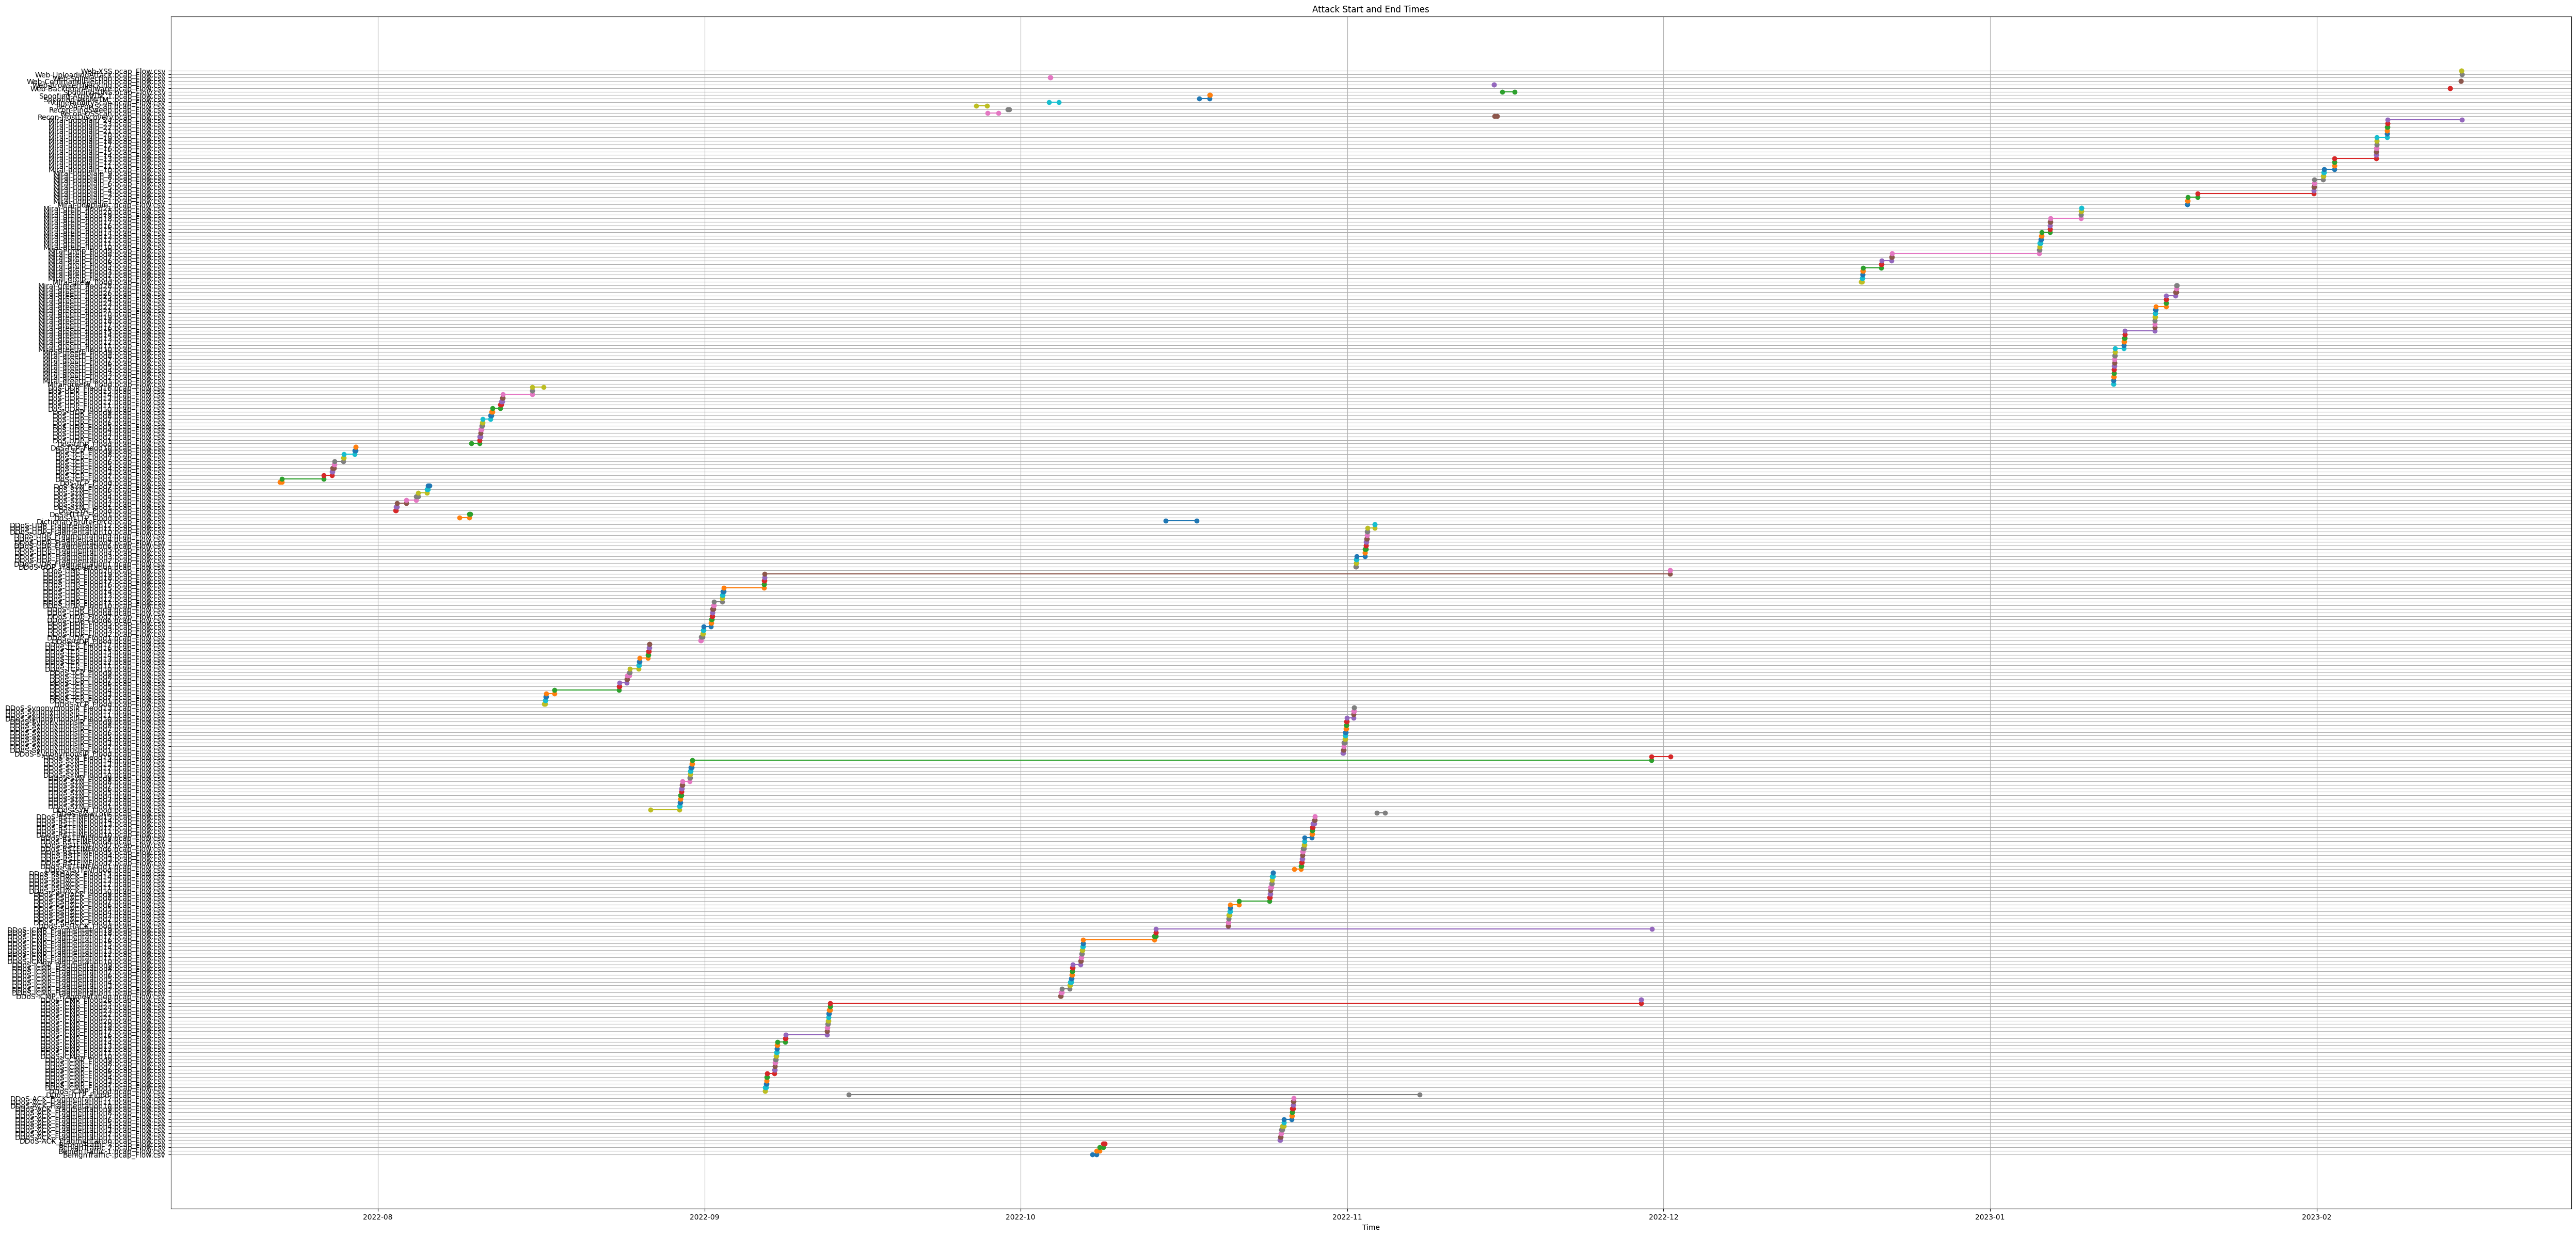

In [10]:
import matplotlib.pyplot as plt

files = list(attack_timestamps.keys())
start_times = [v['Start Time'] for v in attack_timestamps.values()]
end_times = [v['End Time'] for v in attack_timestamps.values()]

plt.figure(figsize=(60, 30))
for i, file in enumerate(files):
    plt.plot([start_times[i], end_times[i]], [i, i], marker='o', label=file)

plt.yticks(range(len(files)), files)
plt.xlabel('Time')
plt.title('Attack Start and End Times')
plt.grid(True)
plt.show()

In [5]:

# Inicializar variables para los valores globales
global_min_time = None
global_max_time = None

# Calcular el mínimo y máximo global
for file, timestamps in attack_timestamps.items():
    start_time = timestamps['Start Time']
    end_time = timestamps['End Time']
    
    # Actualizar el mínimo global
    if global_min_time is None or start_time < global_min_time:
        global_min_time = start_time
    
    # Actualizar el máximo global
    if global_max_time is None or end_time > global_max_time:
        global_max_time = end_time

# Mostrar los tiempos globales en formato fecha y hora
print(f"Inicio de los ataques: {global_min_time}")
print(f"Fin de los ataques: {global_max_time}")

# Calcular la diferencia en segundos
if global_min_time and global_max_time:
    time_diff_seconds = int((global_max_time - global_min_time).total_seconds())
    
    # Mostrar resultados en segundos
    print(f"Diferencia total en segundos: {time_diff_seconds}")
else:
    print("No se encontraron datos válidos para calcular los tiempos.")


Inicio de los ataques: 2022-07-22 16:41:31
Fin de los ataques: 2023-02-14 18:37:57
Diferencia total en segundos: 17891786


In [6]:
# Separar los archivos por clase y tipo de ataque
attack_classes = {}
specific_classes_to_split = {"DDoS"}  # Clases que requieren distinguir tipos más específicos

# Definir los 12 tipos esperados para la clase "DDoS"
ddos_types_expected = {
    "ACK_Fragmentation",
    "UDP_Flood",
    "SlowLoris",  # Agregado para asegurar reconocimiento
    "ICMP_Flood",
    "RSTFINFlood",
    "PSHACK_Flood",
    "HTTP_Flood",
    "UDP_Fragmentation",
    "ICMP_Fragmentation",
    "TCP_Flood",
    "SYN_Flood",
    "SynonymousIP_Flood"
}

for file, timestamps in attack_timestamps.items():
    # Verificar si el archivo contiene un guion '-' para separar clase y tipo
    if '-' in file:
        # Obtener la clase del ataque (lo que está antes del primer guion '-')
        attack_class = file.split('-')[0]

        # Obtener el segmento después del primer guion
        type_segment = file.split('-')[1]

        # Decidir cómo procesar según la clase
        if attack_class in specific_classes_to_split:
            # Limpiar el tipo eliminando números y extensiones como .pcap, .pcap_Flow.csv
            attack_type_raw = type_segment.split('_')[0] + ('_' + type_segment.split('_')[1] if '_' in type_segment else '')
            attack_type = ''.join([char for char in attack_type_raw if not char.isdigit()]).split('.')[0]

            # Verificar si el subtipo pertenece a los 12 tipos esperados
            if attack_type not in ddos_types_expected:
                print(f"Tipo no reconocido: {attack_type} en archivo {file}")
                continue  # Ignorar archivos no reconocidos
        else:
            # Para otras clases, solo considerar el primer segmento como tipo
            attack_type = type_segment.split('_')[0]
    else:
        # Si no hay guion, considerar el archivo completo como la clase y un tipo genérico
        attack_class = file
        attack_type = "Generic"

    # Inicializar estructura para la clase si no existe
    if attack_class not in attack_classes:
        attack_classes[attack_class] = {}

    # Inicializar estructura para el tipo dentro de la clase si no existe
    if attack_type not in attack_classes[attack_class]:
        attack_classes[attack_class][attack_type] = []

    # Añadir los timestamps al tipo de ataque correspondiente
    attack_classes[attack_class][attack_type].append(timestamps)

# Calcular el rango temporal y duración total por clase y tipo
for attack_class, types in attack_classes.items():
    print(f"\n=== {attack_class.upper()} ===")
    for attack_type, timestamps in types.items():
        # Calcular rango temporal para cada tipo de ataque
        min_time = min([t['Start Time'] for t in timestamps])
        max_time = max([t['End Time'] for t in timestamps])

        # Calcular duración total en segundos
        time_diff_seconds = int((max_time - min_time).total_seconds())

        # Mostrar los resultados con la etiqueta del tipo de ataque
        print(f"\nTipo de ataque: {attack_type}")
        print(f"  Inicio: {min_time}")
        print(f"  Fin: {max_time}")
        print(f"  Duración total (segundos): {time_diff_seconds}")



=== BENIGNTRAFFIC ===

Tipo de ataque: .pcap
  Inicio: 2022-10-07 19:15:00
  Fin: 2022-10-08 04:30:27
  Duración total (segundos): 33327

Tipo de ataque: 1.pcap
  Inicio: 2022-10-08 04:30:28
  Fin: 2022-10-08 11:45:20
  Duración total (segundos): 26092

Tipo de ataque: 2.pcap
  Inicio: 2022-10-08 11:45:21
  Fin: 2022-10-08 19:47:19
  Duración total (segundos): 28918

Tipo de ataque: 3.pcap
  Inicio: 2022-10-08 19:47:21
  Fin: 2022-10-08 23:15:00
  Duración total (segundos): 12459

=== DDOS ===

Tipo de ataque: ACK_Fragmentation
  Inicio: 2022-10-25 14:26:00
  Fin: 2022-10-26 22:21:00
  Duración total (segundos): 114900

Tipo de ataque: HTTP_Flood
  Inicio: 2022-09-14 15:47:00
  Fin: 2022-11-07 20:46:00
  Duración total (segundos): 4683540

Tipo de ataque: ICMP_Flood
  Inicio: 2022-09-06 17:57:00
  Fin: 2022-11-28 21:01:59
  Duración total (segundos): 7182299

Tipo de ataque: ICMP_Fragmentation
  Inicio: 2022-10-04 18:55:00
  Fin: 2022-11-29 21:40:59
  Duración total (segundos): 484835

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Datos procesados en formato lista de diccionarios
datos = [
    {"tipo": "Benigno", "inicio": "2022-10-07 19:15:00", "fin": "2022-10-08 04:30:27"},
    {"tipo": "DDOS - ACK_Fragmentation", "inicio": "2022-10-25 14:26:00", "fin": "2022-10-26 22:21:00"},
    {"tipo": "DDOS - HTTP_Flood", "inicio": "2022-09-14 15:47:00", "fin": "2022-11-07 20:46:00"},
    {"tipo": "DDOS - ICMP_Flood", "inicio": "2022-09-06 17:57:00", "fin": "2022-11-28 21:01:59"},
    {"tipo": "DDOS - ICMP_Fragmentation", "inicio": "2022-10-04 18:55:00", "fin": "2022-11-29 21:40:59"},
    {"tipo": "DDOS - PSHACK_Flood", "inicio": "2022-10-20 15:55:00", "fin": "2022-10-24 22:28:00"},
    {"tipo": "DDOS - RSTFINFlood", "inicio": "2022-10-26 22:43:00", "fin": "2022-10-28 22:14:00"},
    {"tipo": "DDOS - SlowLoris", "inicio": "2022-11-03 19:18:00", "fin": "2022-11-04 14:23:59"},
    {"tipo": "DDOS - SYN_Flood", "inicio": "2022-08-26 20:18:00", "fin": "2022-12-01 15:43:00"},
    {"tipo": "DDOS - SynonymousIP_Flood", "inicio": "2022-10-31 13:49:00", "fin": "2022-11-01 15:41:59"},
    {"tipo": "DDOS - TCP_Flood", "inicio": "2022-08-16 18:33:00", "fin": "2022-08-26 18:16:00"},
    {"tipo": "DDOS - UDP_Flood", "inicio": "2022-08-31 15:19:00", "fin": "2022-12-01 15:23:58"},
    {"tipo": "DDOS - UDP_Fragmentation", "inicio": "2022-11-01 18:44:00", "fin": "2022-11-03 14:52:00"},
    {"tipo": "DICTIONARYBRUTEFORCE - Generic", "inicio": "2022-10-14 18:18:00", "fin": "2022-10-17 17:02:00"},
    {"tipo": "DOS - HTTP", "inicio": "2022-08-08 18:25:00", "fin": "2022-08-09 18:22:00"},
    {"tipo": "DOS - SYN", "inicio": "2022-08-02 15:42:00", "fin": "2022-08-05 21:07:00"},
    {"tipo": "DOS - TCP", "inicio": "2022-07-22 16:41:31", "fin": "2022-07-29 22:07:00"},
    {"tipo": "DOS - UDP", "inicio": "2022-08-09 20:37:00", "fin": "2022-08-16 18:05:00"},
    {"tipo": "MIRAI - greeth", "inicio": "2023-01-12 16:19:00", "fin": "2023-01-18 16:52:01"},
    {"tipo": "MIRAI - greip", "inicio": "2022-12-19 17:23:00", "fin": "2023-01-09 16:26:00"},
    {"tipo": "MIRAI - udpplain", "inicio": "2023-01-19 16:51:00", "fin": "2023-02-14 18:37:57"},
    {"tipo": "RECON - HostDiscovery", "inicio": "2022-11-14 23:38:00", "fin": "2022-11-15 05:16:16"},
    {"tipo": "RECON - OSScan", "inicio": "2022-09-27 20:07:00", "fin": "2022-09-28 21:38:00"},
    {"tipo": "RECON - PingSweep", "inicio": "2022-09-29 18:58:00", "fin": "2022-09-29 21:29:00"},
    {"tipo": "RECON - PortScan", "inicio": "2022-09-26 18:31:00", "fin": "2022-09-27 19:16:00"},
    {"tipo": "SPOOFING - ArpMITM", "inicio": "2022-10-17 22:20:00", "fin": "2022-10-18 22:56:00"},
    {"tipo": "SPOOFING - DNS", "inicio": "2022-11-15 17:16:00", "fin": "2022-11-16 21:25:00"},
]

# Convertir las fechas a formato datetime
for d in datos:
    d["inicio"] = datetime.strptime(d["inicio"], "%Y-%m-%d %H:%M:%S")
    d["fin"] = datetime.strptime(d["fin"], "%Y-%m-%d %H:%M:%S")

# Crear la figura
fig, ax = plt.subplots(figsize=(12, 8))

# Dibujar las líneas
for i, d in enumerate(datos):
    color = "green" if "Benigno" in d["tipo"] else "red"
    ax.plot([d["inicio"], d["fin"]], [i, i], marker="o", linestyle="-", color=color, linewidth=2)

# Configurar etiquetas
ax.set_yticks(range(len(datos)))
ax.set_yticklabels([d["tipo"] for d in datos], fontsize=8)
ax.set_xlabel("Fecha", fontsize=12)
ax.set_title("Línea de tiempo de ataques informáticos", fontsize=14)

# Mejorar formato del eje X
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

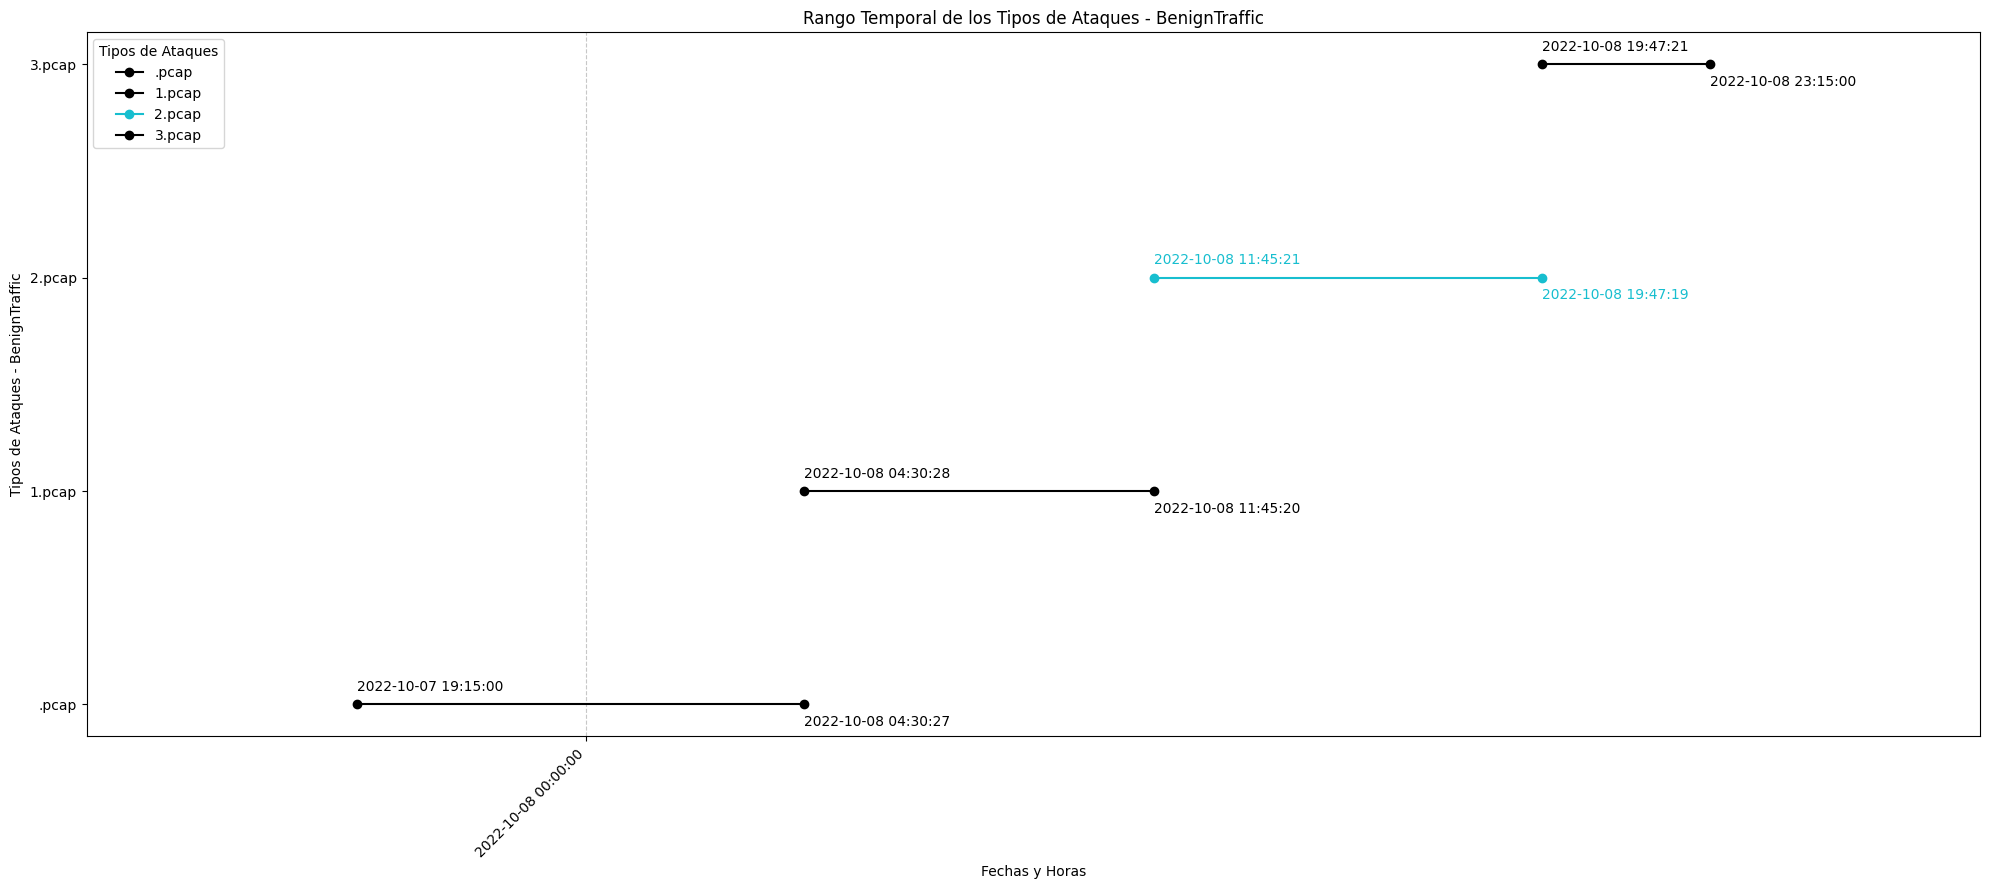

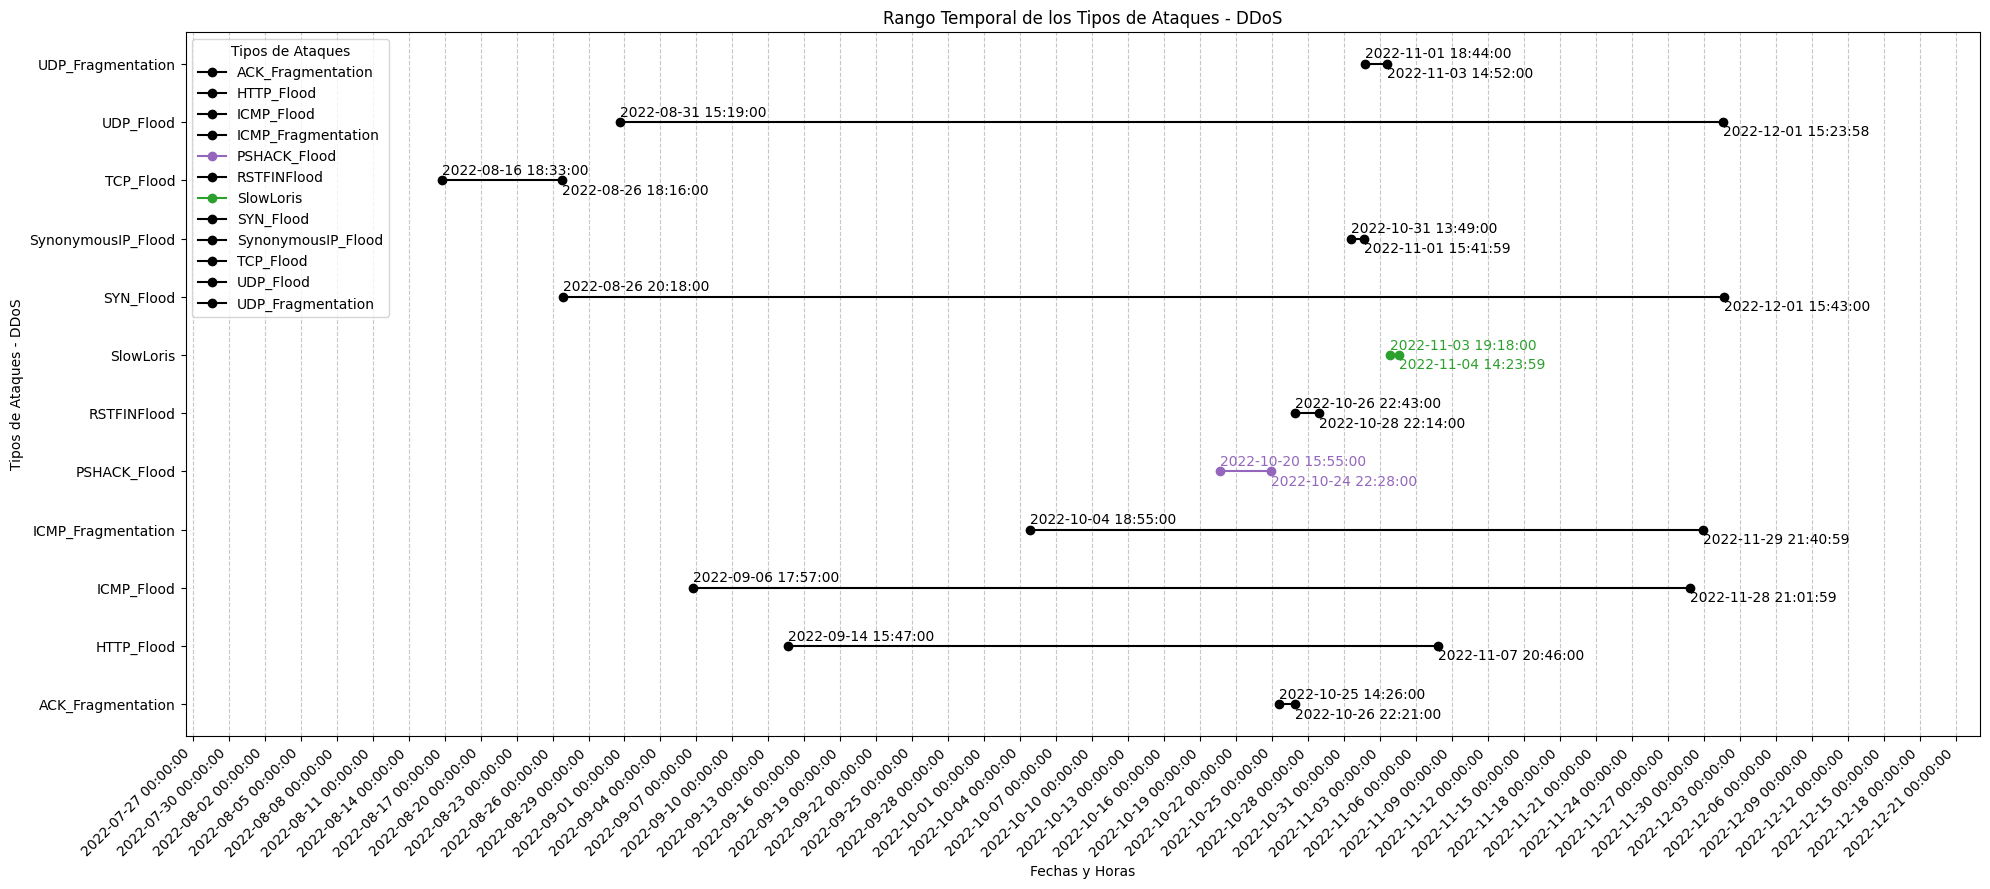

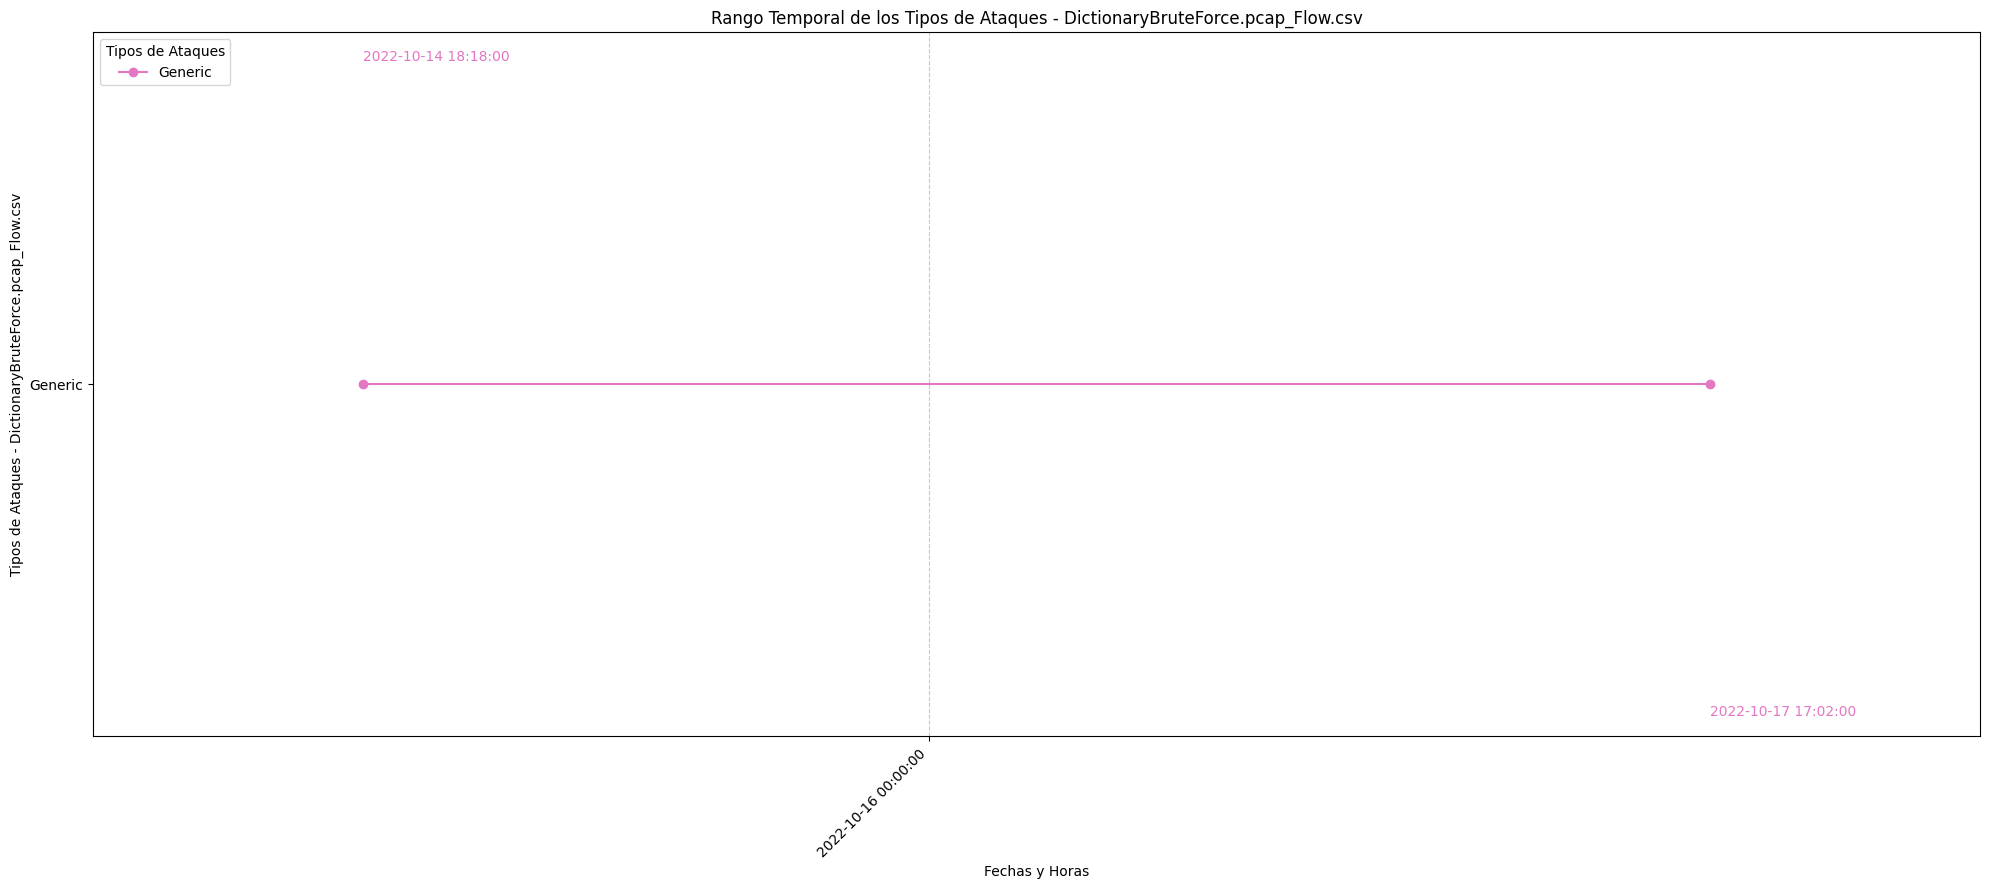

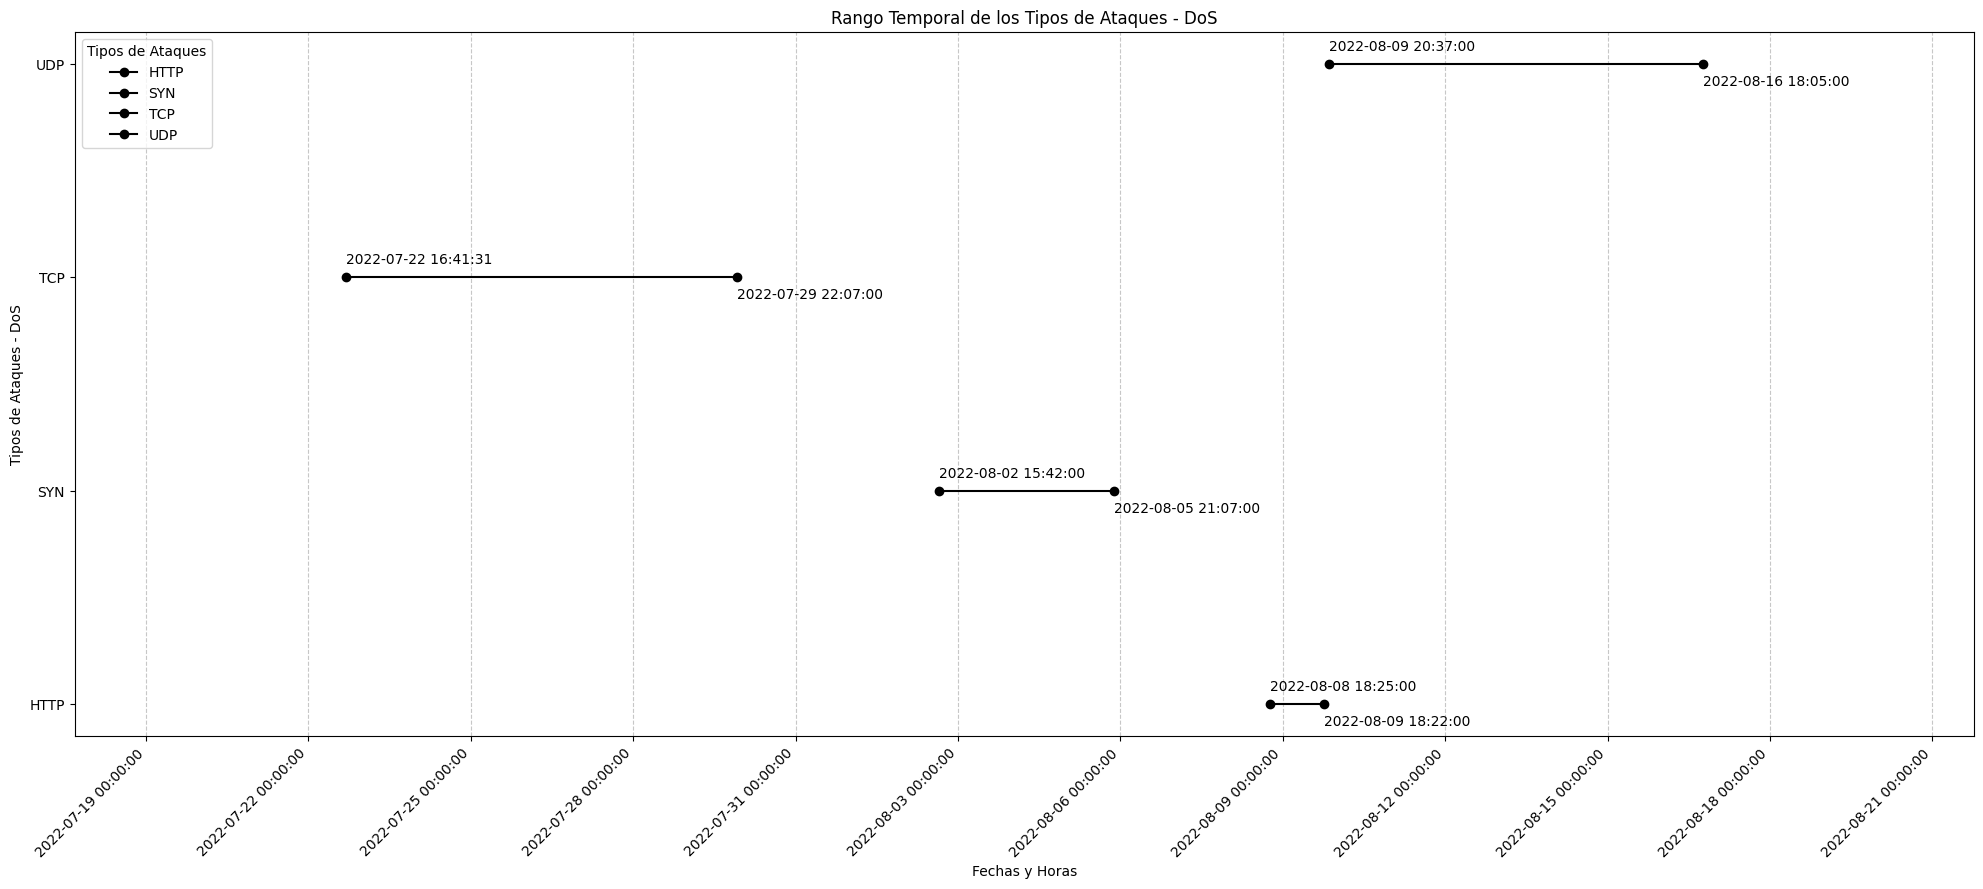

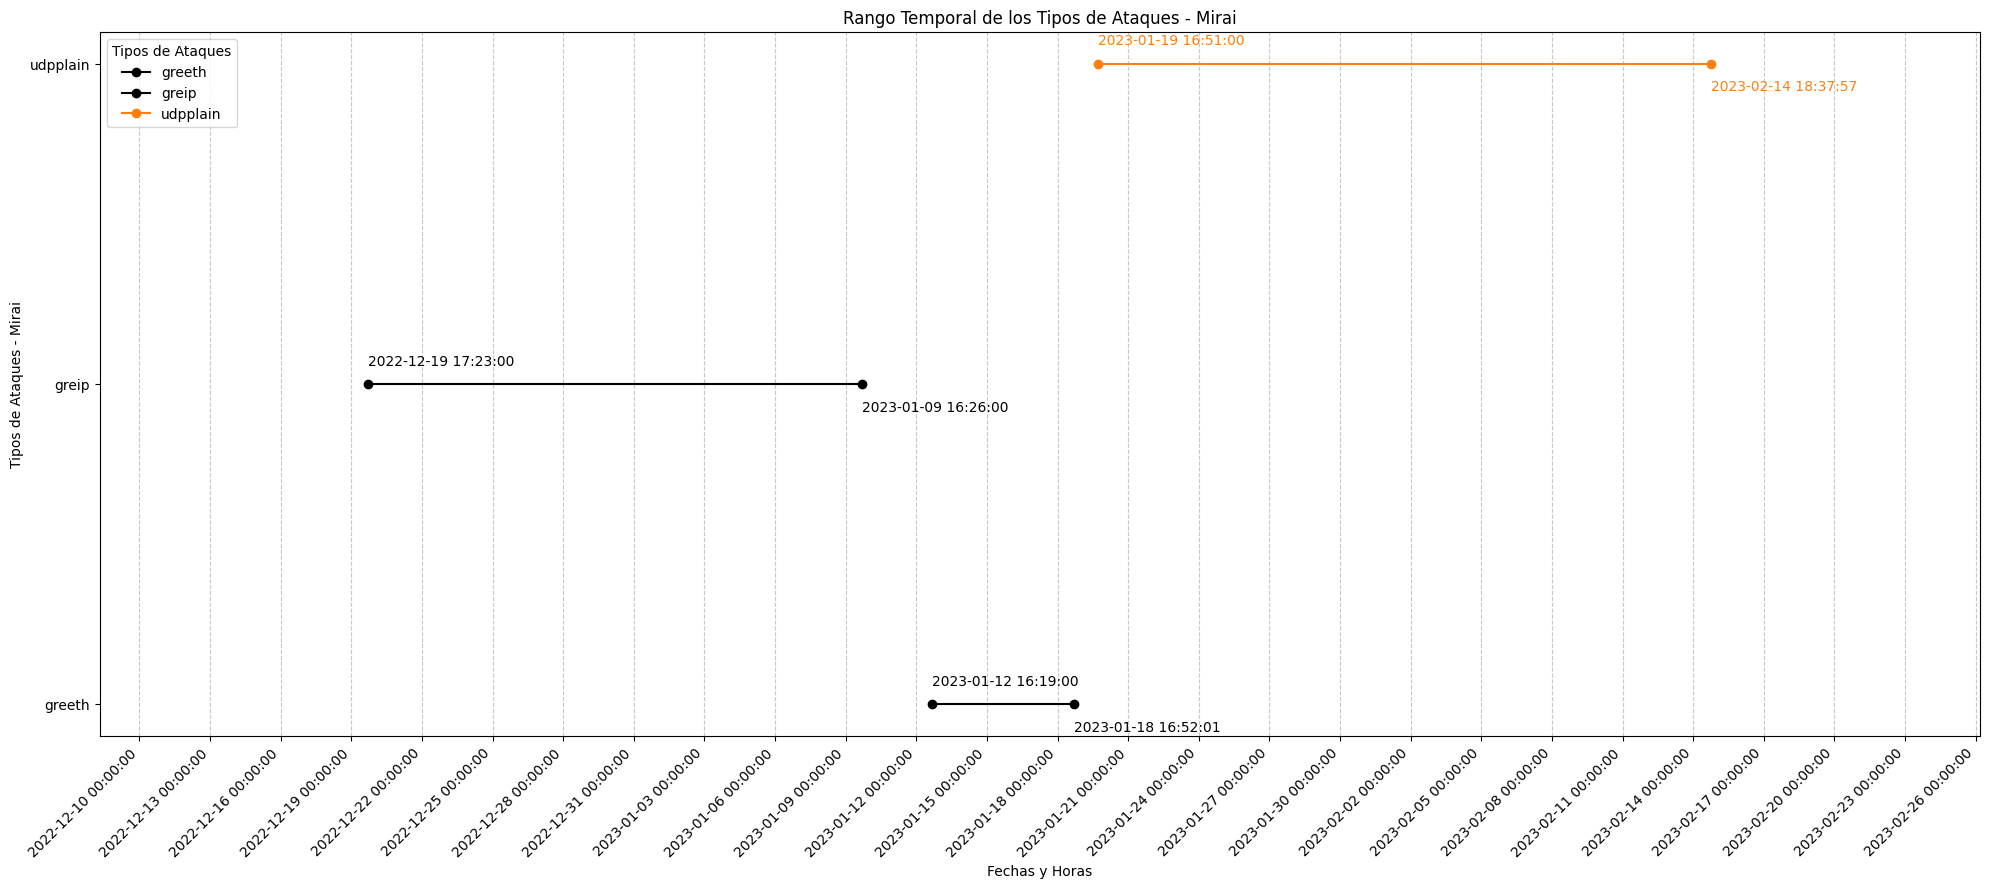

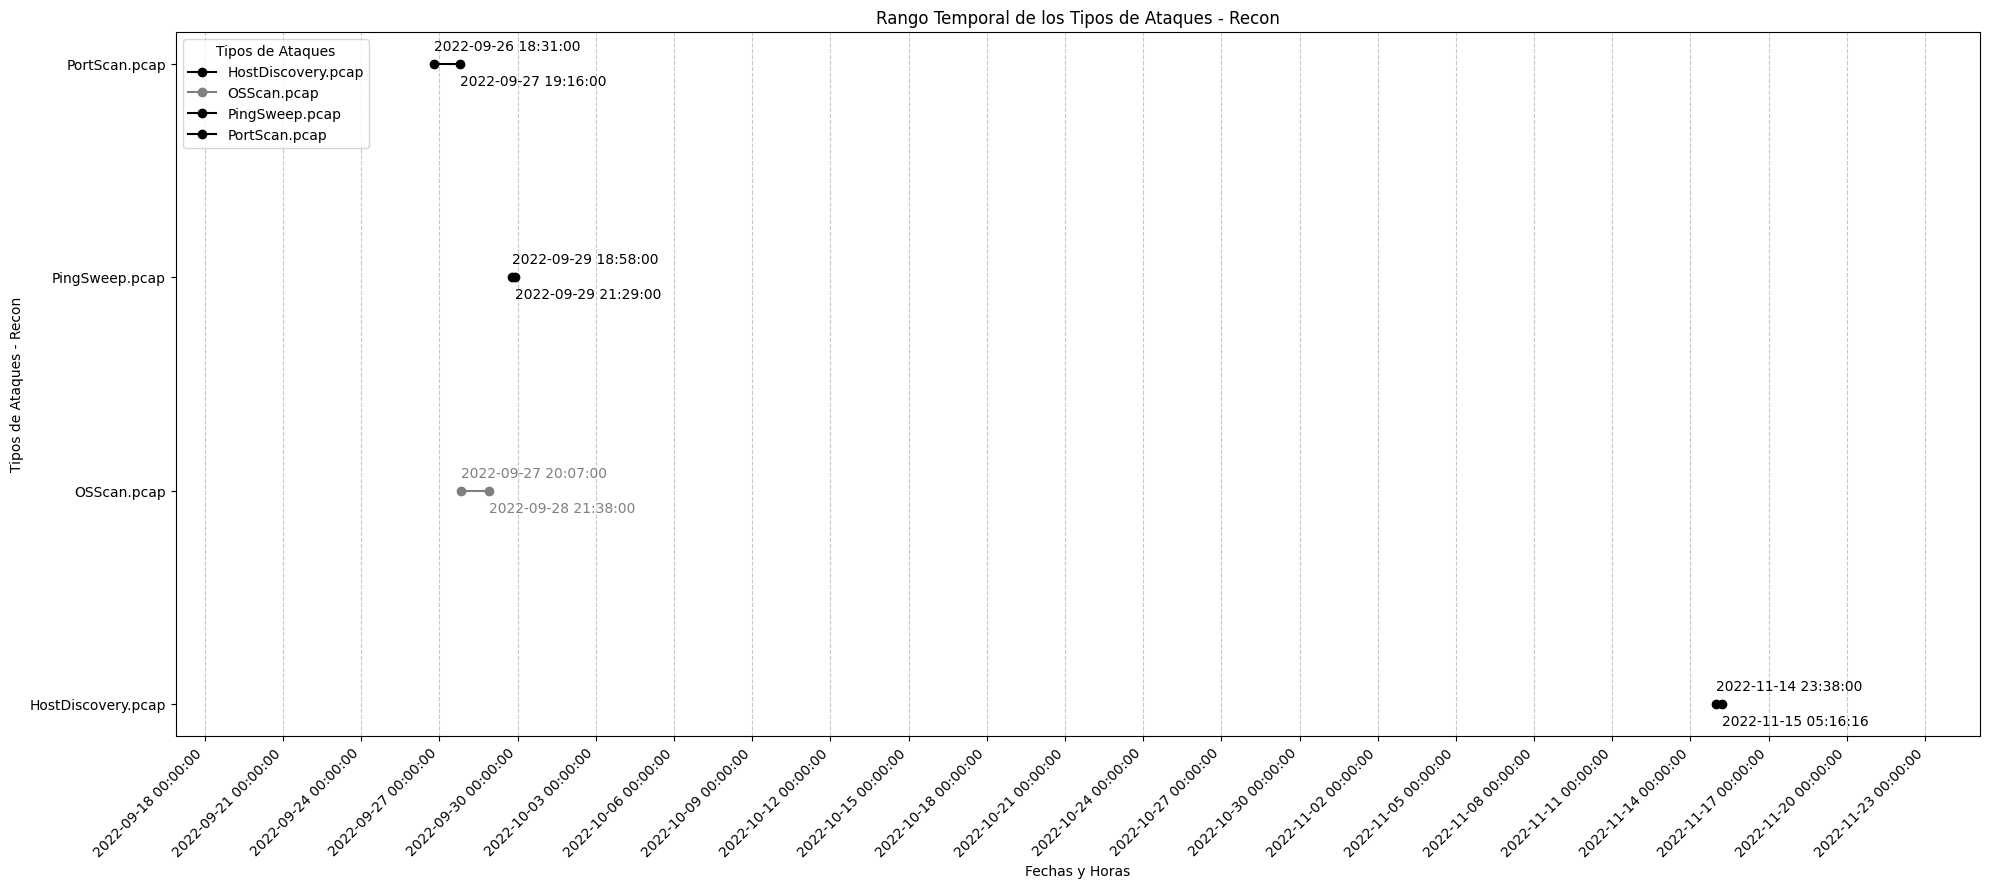

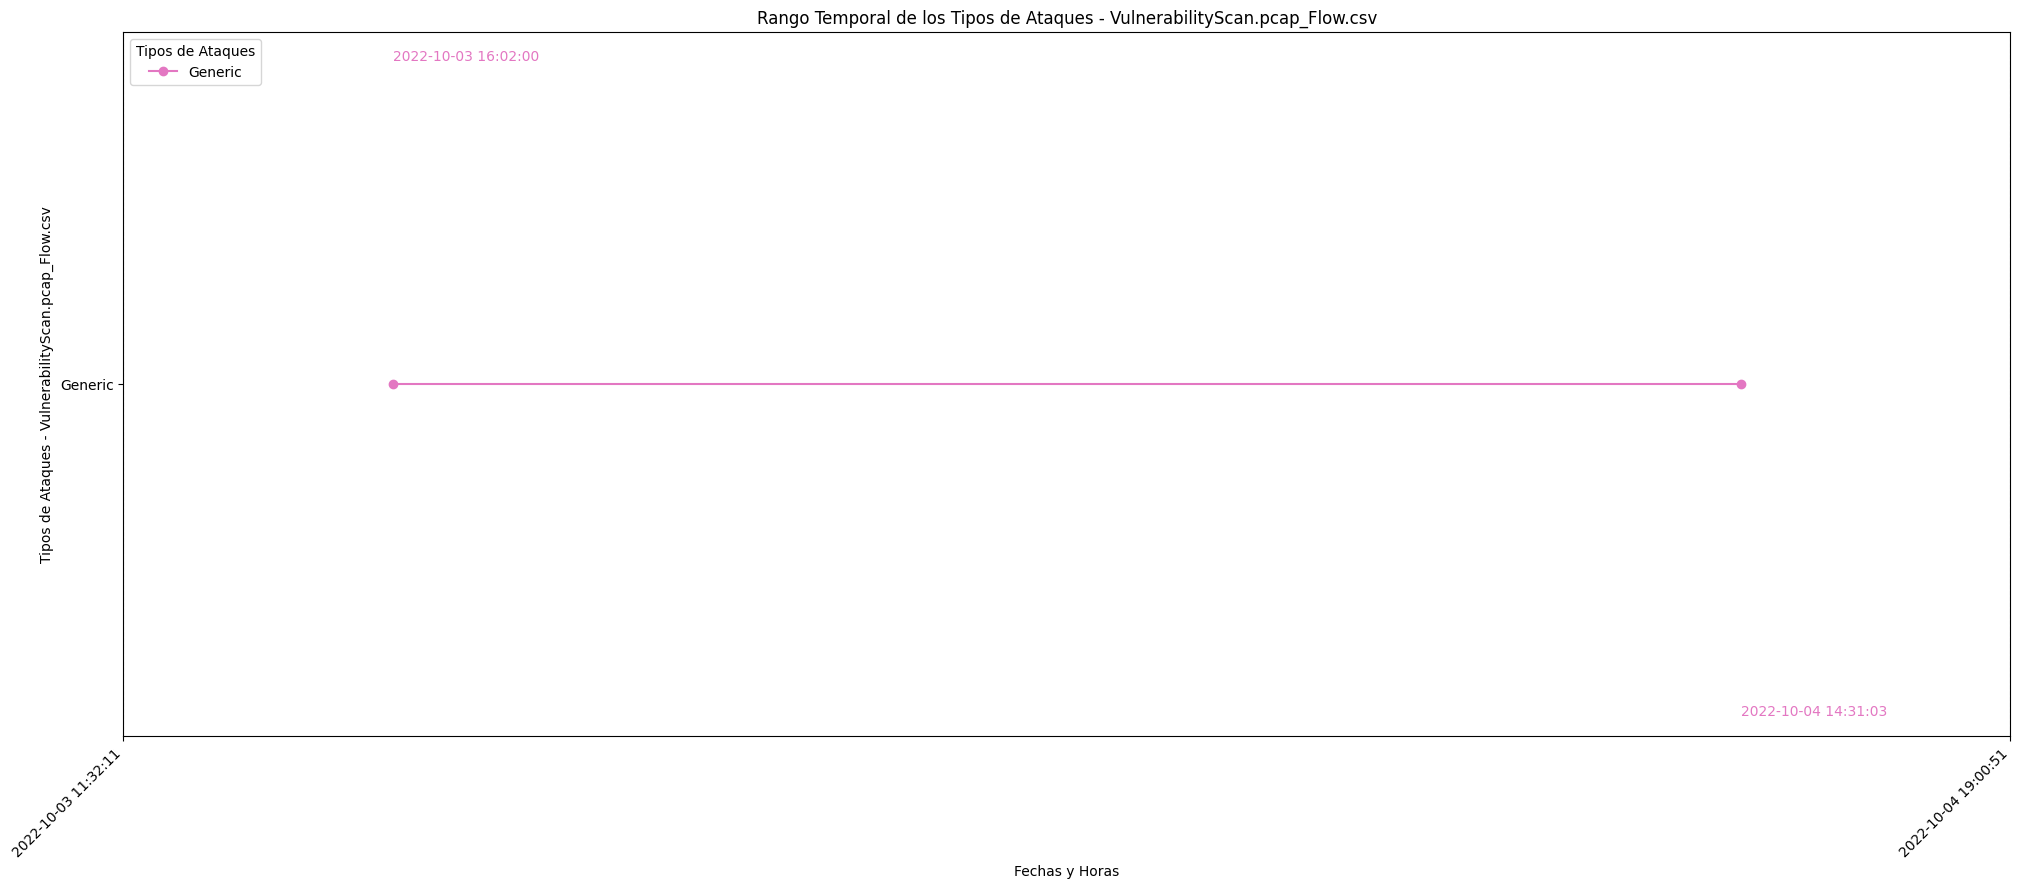

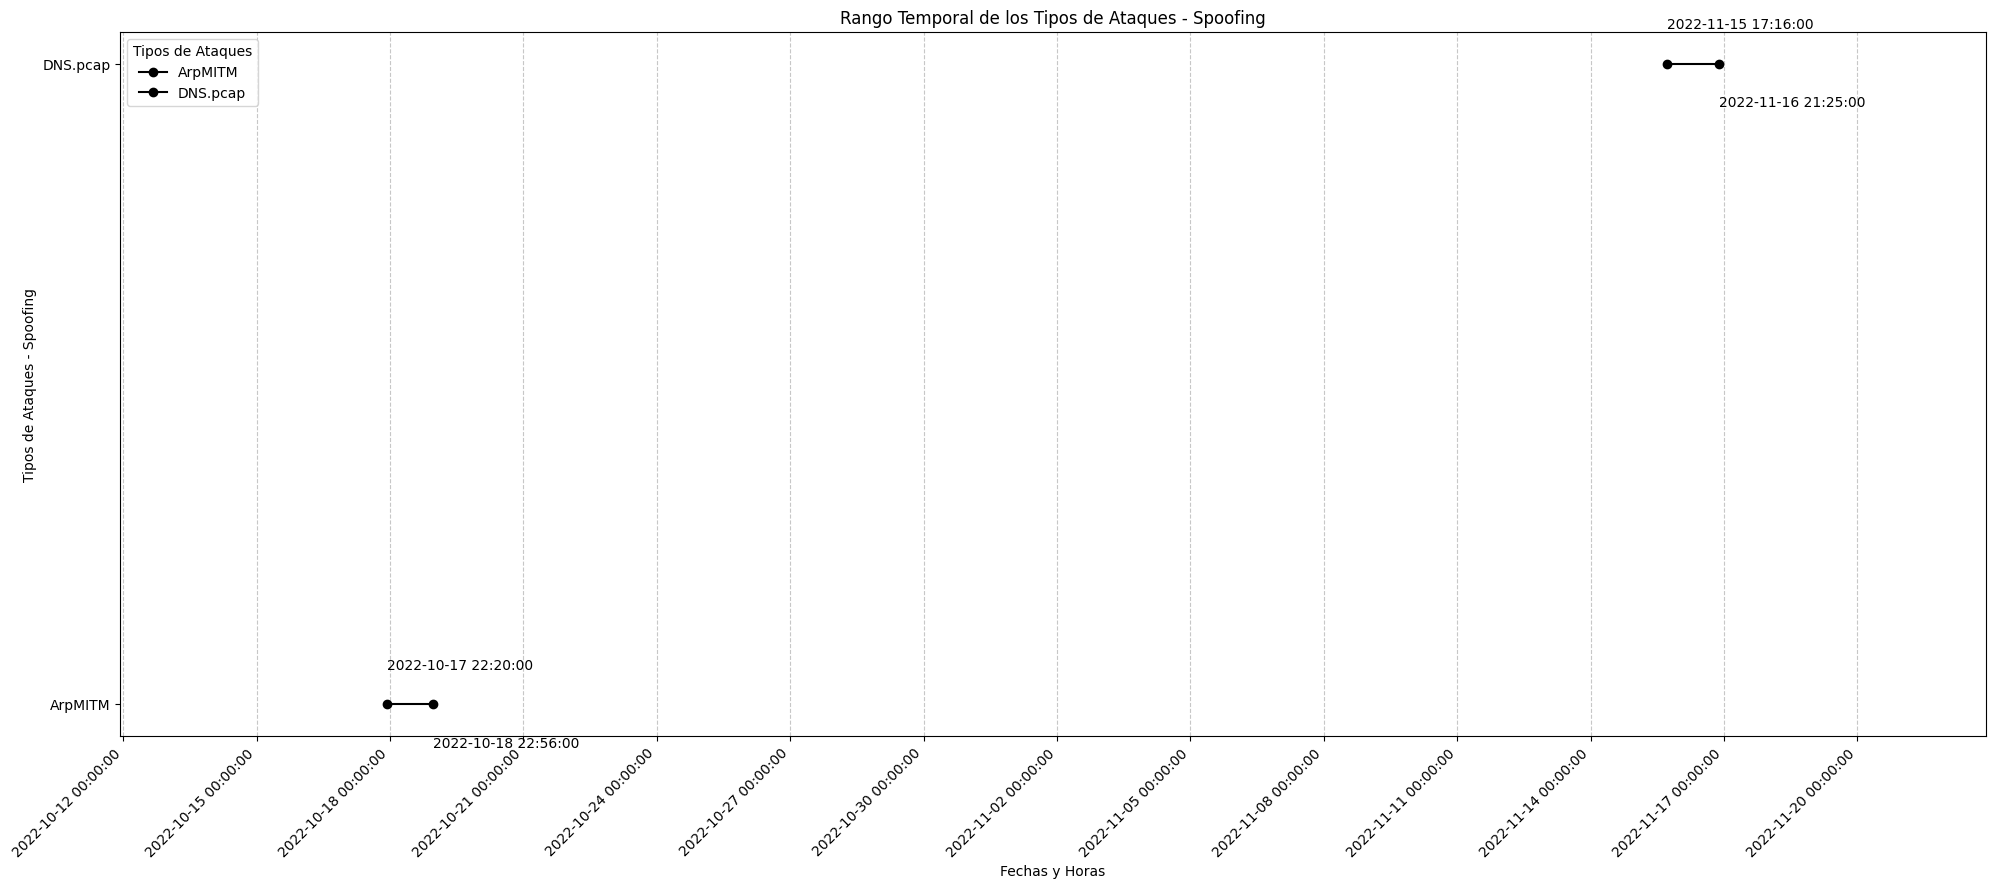

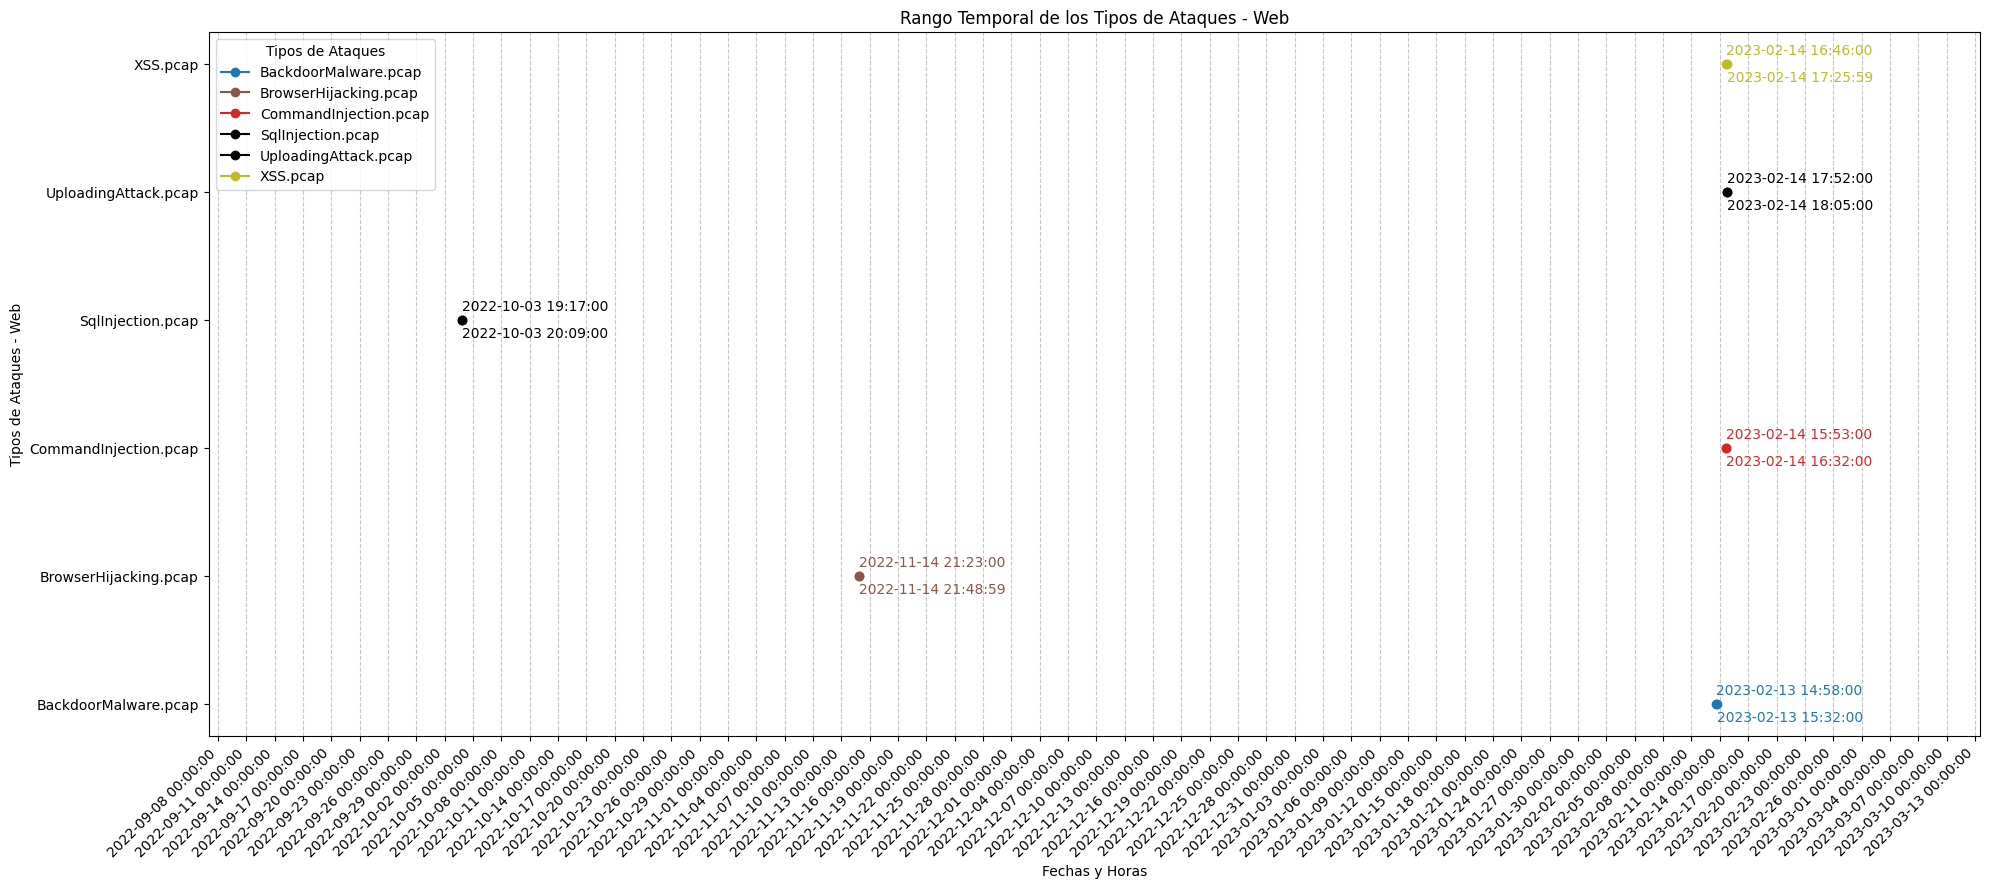

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import random

# Generar colores únicos dinámicamente para cualquier tipo de ataque
available_colors = list(mcolors.TABLEAU_COLORS.values())
random.shuffle(available_colors)  # Mezclar colores para evitar patrones

attack_types_all = set()
for types in attack_classes.values():
    attack_types_all.update(types.keys())

attack_colors = {attack_type: available_colors.pop() for attack_type in attack_types_all if available_colors}

# Preparar datos específicos para la representación de cualquier clase
for attack_class, types in attack_classes.items():
    attack_data = []
    for attack_type, timestamps in types.items():
        min_time = min([t['Start Time'] for t in timestamps])
        max_time = max([t['End Time'] for t in timestamps])
        attack_data.append((attack_type, min_time, max_time))

    # Crear un DataFrame para facilitar la representación
    timeline_df = pd.DataFrame(attack_data, columns=["Type", "Start Time", "End Time"])

    # Mapear tipos de ataque a posiciones numéricas para el eje Y
    type_positions = {attack_type: idx for idx, attack_type in enumerate(timeline_df["Type"].unique())}

    # Generar la representación gráfica para la clase actual
    plt.figure(figsize=(20, 8))
    for idx, row in timeline_df.iterrows():
        y_pos = type_positions[row["Type"]]  # Obtener la posición numérica del tipo
        color = attack_colors.get(row["Type"], 'black')  # Color según el tipo de ataque
        plt.plot([row["Start Time"], row["End Time"]], [y_pos, y_pos], marker='o', color=color, label=row["Type"] if row["Type"] not in plt.gca().get_legend_handles_labels()[1] else "")
        # Añadir etiquetas para el inicio y fin con un desplazamiento vertical para evitar solapamiento
        plt.text(row["Start Time"], y_pos + 0.05, row["Start Time"].strftime('%Y-%m-%d %H:%M:%S'), 
                 verticalalignment='bottom', fontsize=10, color=color)
        plt.text(row["End Time"], y_pos - 0.05, row["End Time"].strftime('%Y-%m-%d %H:%M:%S'), 
                 verticalalignment='top', fontsize=10, color=color)

    # Ajustar el eje Y para mostrar los nombres de los tipos de ataque
    plt.yticks(list(type_positions.values()), list(type_positions.keys()))

    # Ajustar límites para aumentar el margen visual
    extra_time = (timeline_df["End Time"].max() - timeline_df["Start Time"].min()) * 0.2  # Añadir 20% al rango
    plt.gca().set_xlim(timeline_df["Start Time"].min() - extra_time, timeline_df["End Time"].max() + extra_time)

    plt.xlabel("Fechas y Horas")
    plt.ylabel(f"Tipos de Ataques - {attack_class}")
    plt.title(f"Rango Temporal de los Tipos de Ataques - {attack_class}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=3))
    plt.legend(title="Tipos de Ataques", loc="upper left")
    plt.show()